In [1]:
  # Import libraries
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scikitplot as skplt

from plotly.offline import iplot

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from tensorflow import keras
from tensorflow.keras import initializers, layers

## Load dataset relating items and skills

In [2]:
datas = list()
originals = list()
masks = list()

for i in range(100):
    data = pd.read_csv('output_data/10_missing/y/Y_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', header=None)
    data_train = np.ones(data.shape)
    data_train[data < 0.5] = 0.
    datas.append(data_train)
    original = pd.read_csv('input_data/y/Yrep' + str(i+1) + '.csv', sep=';', header=None)
    originals.append(original.values.reshape((180, 10000)).transpose()[:8000, :])
    masks.append(pd.read_csv('output_data/10_missing/masked/Masked_rep' + str(i+1) + '_10_missing.csv', sep=';', header=None))


In [3]:
Q = pd.read_csv('input_data/qmatrix/Qmatrix.csv', sep=';', header=None)
Q = Q.T
print(Q.shape)

(21, 180)


In [4]:
for d, m, o in zip(datas, masks, originals):

    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m.iloc[i, j] != -1 and d[i, j] != o[i, j]:
                d[i, j] = o[i, j]

In [6]:
print(datas)

[array([[0., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]]), array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]]), array([[1., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]]), array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.]]), array([[0., 0., 1., ..., 1., 1.

In [5]:
# Set stats and skills
num_stats = datas[0].shape[1] 
num_skills = 21

intermediate_dim=40

# Number of subjects
N = datas[0].shape[0]
# Training number
tr = N
batch_size = 50
epochs = 100

In [7]:
""" Helper functions """

# Restrict connection in decoder
def q_constraint(w):
    target = w * Q
    diff = w - target
    w = w * tf.cast(tf.math.equal(diff, 0), keras.backend.floatx()) 
    return w * tf.cast(tf.math.greater_equal(w, 0), keras.backend.floatx())

# Remove zeros function
def remove_zeros(arr):
  n_arr = []
  
  for j in range(num_skills): 
    for i in range(num_stats):
      if Q.iloc[j, i] != 0:
        n_arr.append(arr[j][i])
  
  return n_arr


In [8]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(keras.Model):
    """Maps items respone to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=num_skills, intermediate_dim=intermediate_dim, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="tanh")
        self.dense_mean = layers.Dense(latent_dim
                                       #, kernel_initializer=initializers.Zeros()
                                       )
        self.dense_log_var = layers.Dense(latent_dim
                                          #, kernel_initializer=initializers.Zeros()
                                          )
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        #tf.print(tf.math.reduce_mean(z_mean))
        z_log_var = self.dense_log_var(x)
        #tf.print(tf.math.reduce_mean(tf.math.exp(0.5 * z_log_var)))

        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(keras.Model):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, latent_dim=num_skills, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        #self.dense_proj = layers.Dense(latent_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim
                                         , activation="sigmoid"
                                         , kernel_constraint=q_constraint
                                         #, kernel_initializer=initializers.Ones()
                                         #, bias_initializer=initializers.Zeros()
                                         )

    def call(self, inputs):
        #x = self.dense_proj(inputs)
        return self.dense_output(inputs)



class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=intermediate_dim,
        latent_dim=num_skills,
        name="autoencoder"
    ):
        super(VariationalAutoEncoder, self).__init__(name=name)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim)

    def call(self, inputs):
        self.z_mean, self.z_log_var, self.z = self.encoder(inputs)
        reconstructed = self.decoder(self.z)
        return reconstructed

    # Loss function
    def vae_loss(self, input, output):
        cross_entropy_loss = (num_stats / 1.0) * keras.losses.binary_crossentropy(input, output)
        kl_loss = -0.5 * tf.reduce_mean(self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var) + 1, axis=-1)
        return cross_entropy_loss + kl_loss

    # Get weights
    def _get_weights(self):
        return self.decoder.trainable_weights

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

In [9]:
thetas = pd.DataFrame()
thetas_logvar = pd.DataFrame()
discrs_hat = pd.DataFrame()
diffs = pd.DataFrame()
preds = pd.DataFrame()

for i in range(100):
    
    vae_q = VariationalAutoEncoder(num_stats, intermediate_dim, num_skills)

    # Optimizer
    #opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
    opt = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    vae_q.compile(optimizer=opt, loss=vae_q.vae_loss, metrics=['binary_accuracy'])

    data_train = datas[i]
    
    history = vae_q.fit(data_train,
                        data_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True)
    # validation_split=0.2
    ba = 0
    for value in history.history['binary_accuracy']:
        ba += value
    print("Binary Accuracy: %.4f" % (ba / epochs))

    encoder = vae_q.get_encoder()
    decoder = vae_q.get_decoder()
    #weights = vae_q.get_decoder().trainable_weights

    weights = vae_q._get_weights()

    discr = weights[0].numpy()
    #print(discr.shape)
    #diff = pd.DataFrame(weights[3].numpy())
    negative_diff = pd.DataFrame(np.negative(weights[1].numpy()))

    # Get latent trait predictions
    thetas_hat, log_var_thetas_hat, z_pred = encoder.predict(data_train)
    pred = decoder.predict_step(z_pred)
    #print(pred)
    #print(thetas_hat)

    # Total score on the test -------
    score = np.apply_over_axes(np.sum, data_train, 1)

    #### Vectoring the matrices Thetas_hat ans discr ####
    theta_hat = np.transpose(thetas_hat).flatten()
    #step_theta_hat = np.transpose(step_thetas_hat.numpy()).flatten()
  
    log_var_theta_hat = np.transpose(log_var_thetas_hat).flatten()
    #step_log_var_theta_hat = np.transpose(step_log_var_thetas_hat.numpy()).flatten()

    discr_hat = remove_zeros(discr)

    # Save results
    theta_est_rep_GUI = pd.DataFrame({'Thetas Estimation': theta_hat, 'Log Var Thetas Estimation': log_var_theta_hat})
    theta_est_rep_GUI.to_csv('output_data/10_missing/theta/thetas_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', index=False)
    thetas['Rep' + str(i+1)] = theta_hat
    thetas_logvar['Rep' + str(i+1)] = log_var_theta_hat

    discr = pd.DataFrame(discr)
    discr.to_csv('output_data/10_missing/a/discr_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', header=None, index=False)

    discr_hat_GUI = pd.DataFrame([discr_hat])
    discr_hat_GUI.to_csv('output_data/10_missing/a/discr_hat_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', header=None, index=False)
    discrs_hat['Rep' + str(i+1)] = discr_hat

    # Save a estimated replication TRANSPOSED
    discr_hat_GUI.T.to_csv(
        'output_data/10_missing/a/discr_hat_rep' + str(i+1) + '_transformer_10_missing_TRANSPOSED.csv', sep=';', header=None, index=False)

    negative_diff.to_csv('output_data/10_missing/b/diff_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', header=None, index=False)
    diffs['Rep' + str(i+1)] = np.negative(weights[1].numpy())

    preds['Rep' + str(i+1)] = pred.numpy().flatten()


Epoch 1/100


2023-07-25 12:22:36.098178: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


160/160 [==============================] - 1s 761us/step - loss: 122.9100 - binary_accuracy: 0.6037
Epoch 2/100
160/160 [==============================] - 0s 759us/step - loss: 119.2464 - binary_accuracy: 0.6306
Epoch 3/100
160/160 [==============================] - 0s 771us/step - loss: 116.5007 - binary_accuracy: 0.6425
Epoch 4/100
160/160 [==============================] - 0s 783us/step - loss: 113.5098 - binary_accuracy: 0.6586
Epoch 5/100
160/160 [==============================] - 0s 752us/step - loss: 111.0616 - binary_accuracy: 0.6692
Epoch 6/100
160/160 [==============================] - 0s 749us/step - loss: 108.7413 - binary_accuracy: 0.6810
Epoch 7/100
160/160 [==============================] - 0s 780us/step - loss: 106.3618 - binary_accuracy: 0.6920
Epoch 8/100
160/160 [==============================] - 0s 854us/step - loss: 104.1681 - binary_accuracy: 0.7012
Epoch 9/100
160/160 [==============================] - 0s 772us/step - loss: 102.2959 - binary_accuracy: 0.7097
Epoc

In [10]:
binary_preds = np.ones(preds.shape)
binary_preds[preds.values < 0.5] = 0.

In [11]:
binary_preds = pd.DataFrame(binary_preds, columns=preds.columns)

In [12]:
# a artificial
a_values = pd.read_csv('input_data/a/a_values.csv', sep=';', header=None)
#a_rep_gui = pd.read_csv('output/discr_hat_transformer_10_missing_TRANSPOSED.csv', sep=';', header=0)

# b artificial
b_values = pd.read_csv('input_data/b/b_values.csv', sep=';', header=None)
#b_rep_gui = pd.read_csv('output/diff_transformer_10_missing.csv', sep=';', header=0)

# theta artificial
theta_values = pd.read_csv('input_data/theta/theta_values.csv', sep=';', header=None)
#theta_rep_gui = pd.read_csv('output/thetas_transformer_10_missing.csv', sep=';', header=0)

## Discriminations

In [13]:
cols = ['a_values']

a_results = pd.DataFrame(columns=cols)

a_results['a_values'] = a_values

a_results = pd.concat([a_results, discrs_hat], axis=1)

In [14]:
a_results['Bias'] = np.sum(a_values.values - discrs_hat.values, axis=1)/100
a_results['RMSE'] = np.sqrt(np.sum((a_values.values - discrs_hat)**2, axis=1)/100)
a_results['Abs Bias'] = np.sum(np.abs(a_values.values - discrs_hat.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/1112998409.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/1112998409.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/1112998409.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [15]:
corrs = []

for column in discrs_hat:
    corrs.append(a_results['a_values'].corr(discrs_hat['Rep1']))

a_results['Corr'] = ""
a_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/741033095.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/741033095.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
a_results

,a_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,1.164934,0.670757,0.688908,0.719090,0.711669,0.714541,0.668901,0.711117,0.706939,0.701068,...,0.723789,0.711763,0.714578,0.668493,0.735334,0.693686,0.468576,0.469062,0.468576,0.877431
1,0.761002,0.450927,0.421964,0.426307,0.471120,0.458748,0.442101,0.457919,0.450793,0.468905,...,0.464712,0.441967,0.433132,0.461685,0.480421,0.442737,0.308880,0.309364,0.308880,
2,0.823079,0.525140,0.560586,0.470424,0.509899,0.500049,0.532886,0.540166,0.516134,0.531400,...,0.469299,0.529333,0.500685,0.515132,0.550667,0.563052,0.297921,0.299368,0.297921,
3,1.507663,0.931216,0.916536,0.974775,0.984358,0.905709,0.924863,0.893505,0.985676,0.961980,...,0.936209,0.908123,0.959951,0.900236,0.934166,0.881262,0.574811,0.575636,0.574811,
4,0.733496,0.473428,0.465158,0.457663,0.488246,0.485902,0.454456,0.464726,0.433384,0.483021,...,0.466622,0.440998,0.441591,0.465477,0.447518,0.483152,0.270584,0.271237,0.270584,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.819945,0.682331,0.695431,0.623843,0.666227,0.736126,0.681213,0.672187,0.700784,0.658116,...,0.673860,0.657712,0.607693,0.582922,0.644236,0.728752,0.144307,0.148582,0.144307,
296,1.348967,1.075005,1.040836,1.042472,1.134468,1.178031,1.110728,1.085971,1.073597,1.102888,...,1.079181,1.130329,1.067791,1.067689,1.030584,1.095402,0.246071,0.251150,0.246071,
297,0.774595,0.550949,0.497932,0.512974,0.576243,0.571667,0.548094,0.529910,0.627275,0.534412,...,0.603283,0.561760,0.629126,0.547949,0.589179,0.595945,0.205780,0.209728,0.205780,
298,1.662084,1.140739,1.024790,1.032667,1.207167,1.065506,1.178203,1.066880,1.211925,1.136806,...,1.139433,1.145782,1.107339,1.032095,1.175180,1.106838,0.533111,0.536172,0.533111,


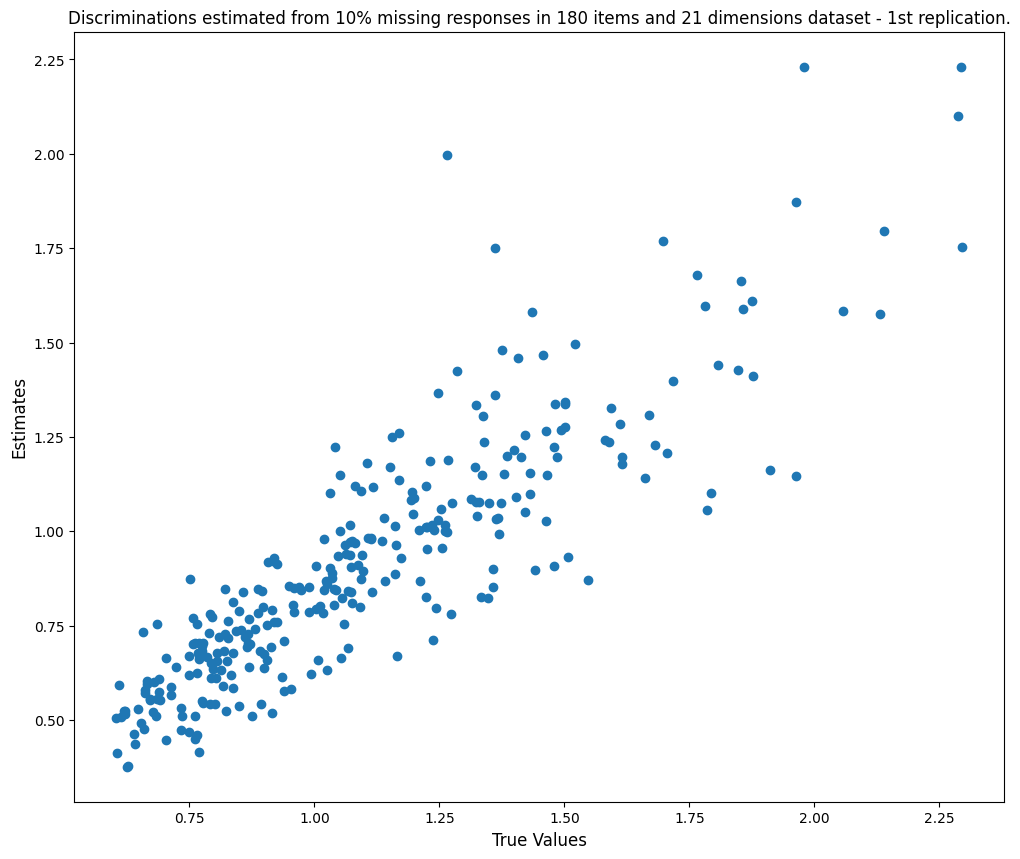

In [17]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=a_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Discriminations estimated from 10% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [18]:
a_results.to_csv('output_data/10_missing/a/a_results.csv', sep=';', header=True, index=False)

## Difficulties

In [19]:
cols = ['b_values']

b_results = pd.DataFrame(columns=cols)

b_results['b_values'] = b_values

b_results = pd.concat([b_results, diffs], axis=1)

In [20]:
b_results['Bias'] = np.sum(b_values.values - diffs.values, axis=1)/100
b_results['RMSE'] = np.sqrt(np.sum((b_values.values - diffs)**2, axis=1)/100)
b_results['Abs Bias'] = np.sum(np.abs(b_values.values - diffs.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/3793169349.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/3793169349.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/3793169349.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [21]:
corrs = []

for column in diffs:
    corrs.append(b_results['b_values'].corr(diffs[column]))

b_results['Corr'] = ""
b_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/713609593.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/713609593.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
b_results

,b_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-0.516250,-0.698375,-0.517684,-0.576271,-0.606279,-0.676286,-0.590680,-0.588032,-0.737028,-0.510479,...,-0.743016,-0.624801,-0.681356,-0.730036,-0.515739,-0.699545,0.120671,0.150067,0.123611,0.972279
1,-0.403987,-0.499898,-0.390374,-0.320142,-0.391411,-0.494412,-0.447673,-0.397600,-0.535365,-0.405094,...,-0.516205,-0.433320,-0.500082,-0.568639,-0.418500,-0.469771,0.053224,0.080727,0.065491,
2,-1.797941,-2.150551,-1.685840,-1.874429,-2.184690,-2.195708,-1.992602,-2.201908,-1.775426,-2.261241,...,-1.832529,-1.812163,-1.767687,-1.870982,-2.221136,-2.257494,0.187858,0.289062,0.214765,
3,0.763532,0.942850,1.592182,1.353921,0.965574,0.704673,1.434767,0.753010,1.502487,0.765562,...,1.302582,1.508545,1.482719,1.558215,0.729093,0.717750,-0.426414,0.547405,0.449007,
4,-0.787187,-0.821659,-0.869540,-0.986571,-1.011181,-0.899353,-1.038411,-0.863975,-1.093886,-0.942369,...,-0.912969,-0.984450,-0.951888,-1.013601,-0.936393,-0.913723,0.205668,0.217221,0.205668,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.660764,0.365525,0.333228,0.371952,0.232992,0.511652,0.492689,0.296695,0.340587,0.202662,...,0.239592,0.445709,0.415354,0.356097,0.396014,0.257438,0.329004,0.350945,0.329004,
176,0.928390,0.634429,0.601941,0.699002,0.525116,0.743332,0.652548,0.657466,0.650604,0.532070,...,0.616935,0.602914,0.676494,0.627134,0.582834,0.573577,0.308131,0.315452,0.308131,
177,-2.073206,-2.192260,-2.177312,-2.148950,-2.165053,-2.171706,-2.149124,-2.151531,-2.102000,-2.114740,...,-2.135694,-2.142045,-2.136760,-2.146357,-2.110982,-2.129093,0.066194,0.076140,0.067099,
178,0.197686,0.229434,0.199812,0.199467,0.218101,0.241676,0.248257,0.218372,0.224793,0.230157,...,0.230704,0.251972,0.222084,0.185890,0.231743,0.215249,-0.018411,0.030962,0.025720,


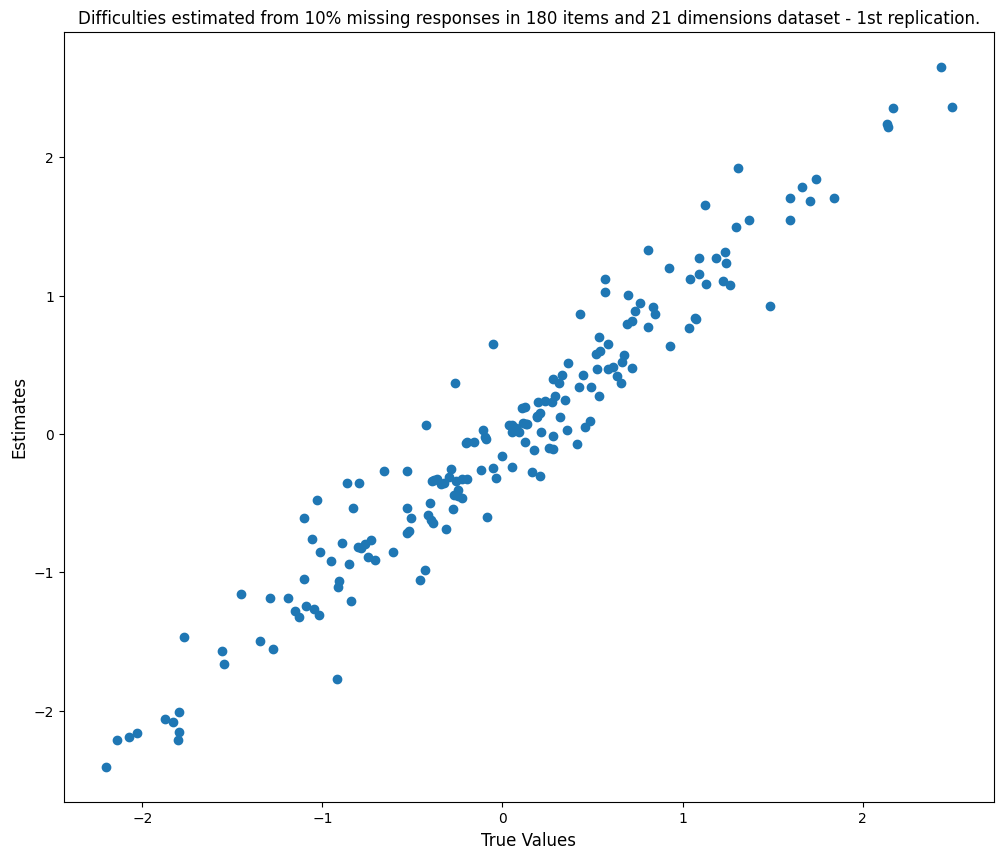

In [23]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values, y=b_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Difficulties estimated from 10% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [24]:
b_results.to_csv('output_data/10_missing/b/b_results.csv', sep=';', header=True, index=False)

## Thetas

In [26]:
theta_values = theta_values.values.reshape((21, 10000))[:, :8000].flatten()

In [27]:
cols = ['theta_values']

theta_results = pd.DataFrame(columns=cols)

theta_results['theta_values'] = theta_values

theta_results = pd.concat([theta_results, thetas], axis=1)


In [28]:
theta_values = theta_values.reshape((theta_values.shape[0], 1))

In [29]:
theta_results['Bias'] = np.sum(theta_values - thetas.values, axis=1)/100
theta_results['RMSE'] = np.sqrt(np.sum((theta_values - thetas)**2, axis=1)/100)
theta_results['Abs Bias'] = np.sum(np.abs(theta_values - thetas.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/3674056909.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/3674056909.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/3674056909.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [30]:
corrs = []

for column in thetas:
    corrs.append(theta_results['theta_values'].corr(thetas[column]))

theta_results['Corr'] = ""
theta_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/2499224961.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_33191/2499224961.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
theta_results

,theta_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-1.255686,-3.020657,-1.543033,-1.836315,-2.213671,-2.095305,-2.128795,-2.963616,-3.319731,-2.498620,...,-2.027771,-2.919722,-2.859336,-3.208607,-1.738007,-2.393536,1.124908,1.284990,1.138852,0.794286
1,0.417691,0.057791,-0.156198,2.089787,0.369140,0.602179,1.220729,0.657540,-0.686444,1.551774,...,-0.311052,0.128234,1.091180,0.541924,1.123585,1.325316,-0.091040,0.818200,0.664161,
2,-0.218857,-0.416524,-1.300954,-1.483239,0.309061,-0.053375,0.078339,0.740837,-0.394811,-1.334125,...,-0.400382,-0.749133,-0.650603,-1.065999,1.152876,-0.315286,0.308244,0.808240,0.658587,
3,0.506261,0.666887,0.242769,0.945216,1.866341,2.499355,2.055869,0.354945,0.680701,0.739211,...,0.081549,0.964846,2.026465,0.298457,0.895025,1.939738,-0.423165,0.824347,0.643859,
4,0.165964,-0.003788,0.065334,1.123972,1.103315,-0.061423,-0.201564,-0.512918,0.865087,0.629098,...,0.366337,1.368361,1.419728,-0.823638,1.156357,-0.429636,0.008550,0.736754,0.596353,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167995,-1.058072,-2.187040,-0.637101,-0.311078,-0.984503,-2.360136,-1.492116,-0.985022,-1.532883,-1.006293,...,-1.329813,-1.700977,-1.970314,-0.650240,-1.266734,-1.832848,0.365755,0.804977,0.667059,
167996,-0.292246,0.542233,-0.564780,1.411943,1.219874,0.476678,-1.476468,0.090605,-0.515633,-0.820224,...,-0.079212,-1.654241,0.488816,-1.742508,-0.456344,-0.835713,0.280780,0.971805,0.831604,
167997,-1.132776,-2.221894,-2.095589,-2.416153,-1.174381,-1.990006,-2.406239,-1.522756,0.107342,-2.568117,...,-2.344076,-1.453737,-1.494021,-1.233702,-1.825515,-2.795914,0.571231,0.935703,0.781879,
167998,0.537725,-0.266335,0.617725,1.508590,1.622611,0.746700,1.563750,0.458590,2.552268,1.988356,...,-0.915648,0.524434,1.034626,-0.158232,0.827891,-0.967823,-0.161149,0.968446,0.769724,


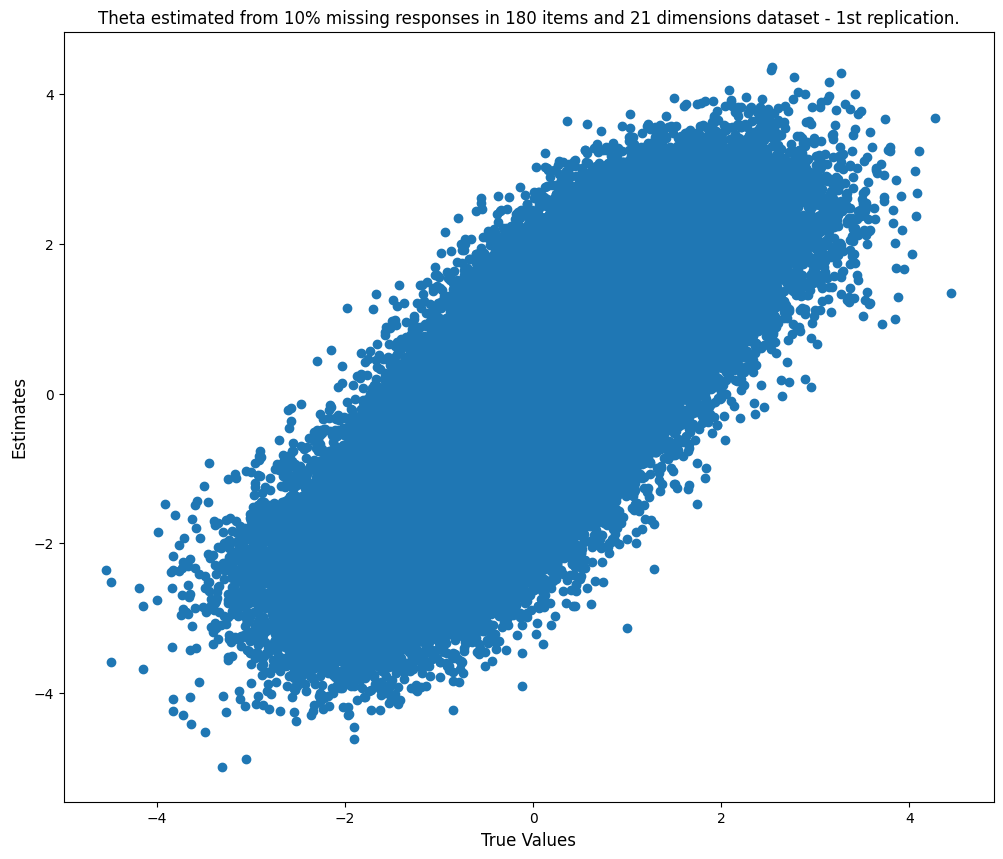

In [32]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Theta estimated from 10% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [33]:
theta_results.to_csv('output_data/10_missing/theta/theta_results.csv', sep=';', header=True, index=False)

In [ ]:
theta_df = pd.DataFrame()
theta_df['Estimate'] = thetas['Rep1']
theta_df['Dim'] = ""
theta_df['Dim'][:8000] = 1
theta_df['Dim'][8000:16000] = 2
theta_df['Dim'][16000:] = 3


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_df['Estimate'], c=theta_df['Dim'], cmap=plt.cm.Set1)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

## Confusion Matrix

In [ ]:
def matrix_metrix(real_values, pred_values):
   CM = confusion_matrix(real_values, pred_values)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   Accuracy   = round( (TP+TN) / Population,4)
   Precision  = round( TP / (TP+FP),4 )
   NPV        = round( TN / (TN+FN),4 )
   FDR        = round( FP / (TP+FP),4 )
   FOR        = round( FN / (TN+FN),4 ) 
   Recall     = round( TP / (TP+FN),4 )
   FPR        = round( FP / (TN+FP),4 )
   FNR        = round( FN / (TP+FN),4 )
   TNR        = round( TN / (TN+FP),4 ) 

   return {#'CM': CM, 
           'TN': TN,
           'FN': FN,
           'TP': TP,
           'FP': FP,
           'Population': Population,
           'Accuracy': Accuracy,
           'Precision': Precision,
           'NPV': NPV,
           'FDR': FDR,
           'FOR': FOR,
           'Recall': Recall,
           'FPR': FPR,
           'FNR': FNR,
           'TNR': TNR
           }

In [ ]:
print(confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1']))
skplt.metrics.plot_confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1'],figsize=(8,8))

In [ ]:
res = matrix_metrix(np.array(originals[0]).flatten(), binary_preds['Rep1'])

df = pd.DataFrame({'Metric': res.keys(), 'Value': res.values()})

print(df)

In [ ]:
fpr, tpr, thresholds = roc_curve(np.array(originals[0]).flatten(), preds['Rep1'])
auc = roc_auc_score(np.array(originals[0]).flatten(), preds['Rep1'])
print('AUC: %.3f' % auc)

plt.plot(fpr, tpr, linestyle='--', label='Roc curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(np.array(originals[0]).flatten(), preds['Rep1'])

plt.plot(recall, precision, linestyle='--', label='Precision versus Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Charts

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=thetas[0]['Thetas Estimation'])
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
print(b_values.shape)
print(negative_diff.shape)

In [ ]:


fig_a = go.Figure()
fig_a.add_trace(go.Scatter(y=discr_hat, mode='lines', name='Python'))
fig_a.add_trace(go.Scatter(y=a_values.iloc[:,0], mode='lines', name='a Real'))
fig_a.update_layout( title="Discrimation")
fig_a.show()

fig_b = go.Figure()
fig_b.add_trace(go.Scatter(y=negative_diff.iloc[:,0], mode='lines', name='Python'))
fig_b.add_trace(go.Scatter(y=b_values.iloc[:,0], mode='lines', name='b Real'))
fig_b.update_layout(title="Difficulty")
fig_b.show()

fig_theta = go.Figure()
#fig_theta.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], mode='lines', name='Python'))
fig_theta.add_trace(go.Scatter(y=theta_values.iloc[:,0], mode='lines', name='Real'))
fig_theta.update_layout( title="Theta Real")
fig_theta.show()

fig_t = go.Figure()
fig_t.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], line=dict(color='green',), mode='lines', name='Python'))
#fig_t.add_trace(go.Scatter(y=theta_rep['Thetas_est'], line=dict(color='green',),mode='lines', name='R'))
fig_t.update_layout( title="Theta Hat Python")
fig_t.show()



In [ ]:
theta_values = theta_values.values.reshape((21, 10000)).transpose()

In [ ]:
print(theta_hat.shape)
print(theta_values[:N, :].flatten().shape)

In [ ]:
print(len(discr))

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values[:N, :].flatten(), y=thetas_hat)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
len(discr_hat)

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=discr_hat)
#plt.colorbar()
plt.xlabel("True Values of a_values")
plt.ylabel("Estimates")
plt.show()


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values.values.flatten(), y=negative_diff)
#plt.colorbar()
plt.xlabel("True Values of b_values")
plt.ylabel("Estimates")
plt.show()